In [1]:
#!/usr/bin/env python3

import paratext
import pandas as pd
import lz4.frame
import gzip
import io
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np

'''
filepath = 'cboe/lz4_test/BTCUSD_order_book_20170627.csv.lz4'
#filepath = 'cboe/lz4_test/BTCUSD_order_book_20170627.csv.gz'
df = pandas.read_csv(io.TextIOWrapper(lz4.frame.open(filepath)))
#df = pandas.read_csv(filepath)
#df = paratext.load_csv_to_pandas(gzip.open(filepath).read())
print((df))
'''

from glob import glob
from plumbum.cmd import rm


In [2]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
def plotline(data):
  plt.figure()
  plt.plot(data)
  plt.legend()
  plt.show()

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 819817833320052369
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7937798964
locality {
  bus_id: 1
}
incarnation: 2234700334524424196
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:

df = pq.read_table('cboe/parquet_fills_only_BTCUSD.parquet').to_pandas()
print(df.dtypes)
print(df.shape)


Event ID                        int64
Event Date                     object
Event Time                     object
Event Millis                    int64
Order ID                        int64
Execution Options              object
Event Type                     object
Symbol                         object
Order Type                     object
Side                           object
Limit Price (USD)             float64
Original Quantity (BTC)       float64
Gross Notional Value (USD)    float64
Fill Price (USD)              float64
Fill Quantity (BTC)           float64
Total Exec Quantity (BTC)     float64
Remaining Quantity (BTC)      float64
Avg Price (USD)               float64
dtype: object
(13474221, 18)


In [6]:
num_samples = df.shape[0] - 2 # subtract 1 because we exclude the first prediction, and another 1 because our feature is price differences
num_samples_training = round(num_samples * 0.9)
num_samples_dev = round(num_samples * 0.05)
num_samples_test = round(num_samples * 0.05)


In [7]:
#train_set = df.iloc[0:num_samples_training]
#dev_set = df.iloc[num_samples_training:num_samples_training+num_samples_dev]
#test_set = df.iloc[num_samples_training+num_samples_dev:]

In [8]:
#small_set = df.iloc[0:10]
#print(small_set)

In [9]:
print(max(df['Event Date'].values.reshape(-1, 1)))

['2018-02-20']


In [10]:
print(max(df['Avg Price (USD)'].values.reshape(-1, 1)))

[19999.]


In [11]:
print(max(df['Limit Price (USD)'].values.reshape(-1, 1)))

[1.2193122e+09]


In [12]:
print(max(df['Fill Price (USD)'].values.reshape(-1, 1)))

[19999.]


In [13]:
price_scaler = MinMaxScaler().fit(df.iloc[0:num_samples_training]['Fill Price (USD)'].values.reshape(-1, 1))

def get_max_min_price(fulldata):
  max_price = data[['Fill Price (USD)']].max().item()
  min_price = data[['Fill Price (USD)']].min().item()
  return {
    'max': max_price,
    'min': min_price
  }



def extract_price_features(fulldata):
  data = fulldata[['Fill Price (USD)', 'Side', 'Order Type']].copy()
  length = data.shape[0]
  data['isbuy'] = pd.get_dummies(data['Side'])['buy'].values
  data['ismarket'] = pd.get_dummies(data['Order Type'])['market'].values
  data['price_scaled'] = price_scaler.transform(data['Fill Price (USD)'].values.reshape(-1, 1)).flatten()
  return data[['price_scaled', 'isbuy', 'ismarket']].iloc[:length - 1].values.astype('float32')[:, None, :]
  #return data[['price_scaled', 'isbuy', 'ismarket']].iloc[:length - 1].values[:, None, :]

def extract_price_features_percentdiff(fulldata):
  data = fulldata[['Fill Price (USD)', 'Side', 'Order Type']].copy()
  length = data.shape[0]
  data['isbuy'] = pd.get_dummies(data['Side'])['buy'].values
  data['ismarket'] = pd.get_dummies(data['Order Type'])['market'].values
  data['price_diff_percent'] = data['Fill Price (USD)'].pct_change()
  return data[['price_diff_percent', 'isbuy', 'ismarket']].iloc[:length - 1].values.astype('float32')[1:, None, :]
  #return data[['price_scaled', 'isbuy', 'ismarket']].iloc[:length - 1].values[:, None, :]


extract_features = extract_price_features_percentdiff

#small_features = extract_features(small_set)

In [14]:
print(extract_price_features_percentdiff(df.iloc[0:10, :]))

[[[0.0000000e+00 0.0000000e+00 1.0000000e+00]]

 [[1.8556701e-03 1.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[4.1160733e-05 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 1.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 1.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 1.0000000e+00 0.0000000e+00]]]


In [15]:
all_features = extract_features(df)

In [16]:
#print(all_features.shape)

In [17]:
#num_samples = all_features.shape[0]
#num_samples_training = round(num_samples * 0.9)
#num_samples_dev = round(num_samples * 0.05)
#num_samples_test = round(num_samples * 0.05)


In [18]:
X_train = all_features[0:num_samples_training, :]
X_dev = all_features[num_samples_training:num_samples_training+num_samples_dev, :]
X_test = all_features[num_samples_training+num_samples_dev:, :]

In [19]:
print(X_train[:,0,0].max())
print(X_train[:,0,0].min())
print(X_dev[:,0,0].max())
print(X_dev[:,0,0].min())
print(X_test[:,0,0].max())
print(X_test[:,0,0].min())

0.52076274
-0.84645456
0.01569
-0.015960207
0.020408338
-0.015900934


In [20]:
def extract_y_rawprice(fulldata):
  prices = fulldata[['Fill Price (USD)']].values.astype('float32')
  #prices = fulldata[['Fill Price (USD)']].values
  prices = price_scaler.transform(fulldata['Fill Price (USD)'].values.reshape(-1, 1)).flatten()
  return np.delete(prices, 0, axis=0).reshape(-1, 1)
  #return np.insert(prices, 0, prices[0])

def extract_y_prevrawprice(fulldata):
  prices = fulldata[['Fill Price (USD)']].values.astype('float32')
  #prices = fulldata[['Fill Price (USD)']].values
  prices = fulldata['Fill Price (USD)'].values.flatten()
  return np.delete(prices, [0, prices.shape[0] - 1], axis=0).reshape(-1, 1)
  #return np.insert(prices, 0, prices[0])

def extract_y_percentdiff(fulldata):
  #prices = fulldata[['Fill Price (USD)']].values
  prices = fulldata['Fill Price (USD)'].pct_change().values.astype('float32')
  return np.delete(prices, [0, 1], axis=0).reshape(-1, 1)
  #return np.insert(prices, 0, prices[0])

extract_y = extract_y_percentdiff

#print(len(extract_y(small_set)))

In [21]:
print(extract_y_prevrawprice(df.iloc[0:10, :]))

[[242.5 ]
 [242.95]
 [242.95]
 [242.96]
 [242.96]
 [242.96]
 [242.96]
 [242.96]]


In [22]:
print(extract_y_percentdiff(df.iloc[0:10, :]))

[[1.8556701e-03]
 [0.0000000e+00]
 [4.1160733e-05]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]


In [23]:
all_y = extract_y(df)
all_y_prevrawprice = extract_y_prevrawprice(df)

In [24]:
print(all_features.shape)
print(all_y.shape)
print(all_features.dtype)
print(all_y.dtype)

(13474219, 1, 3)
(13474219, 1)
float32
float32


In [25]:
Y_train = all_y[0:num_samples_training, :]
Y_dev = all_y[num_samples_training:num_samples_training+num_samples_dev, :]
Y_test = all_y[num_samples_training+num_samples_dev:, :]

In [26]:
Y_train_prevrawprice = all_y_prevrawprice[0:num_samples_training, :]
Y_dev_prevrawprice = all_y_prevrawprice[num_samples_training:num_samples_training+num_samples_dev, :]
Y_test_prevrawprice = all_y_prevrawprice[num_samples_training+num_samples_dev:, :]

In [27]:
print(Y_train[:,0].max())
print(Y_train[:,0].min())
print(Y_dev[:,0].max())
print(Y_dev[:,0].min())
print(Y_test[:,0].max())
print(Y_test[:,0].min())

0.52076274
-0.84645456
0.01569
-0.015960207
0.020408338
-0.015900934


No handles with labels found to put in legend.


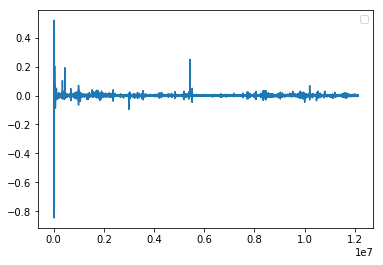

No handles with labels found to put in legend.


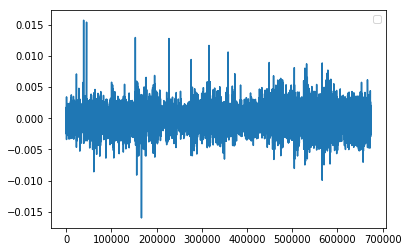

No handles with labels found to put in legend.


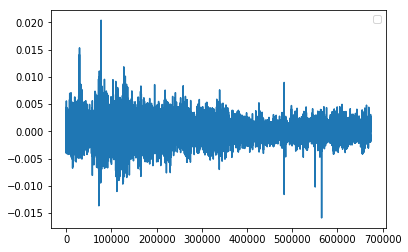

In [28]:
plotline(X_train[:,0,0])
plotline(X_dev[:,0,0])
plotline(X_test[:,0,0])

No handles with labels found to put in legend.


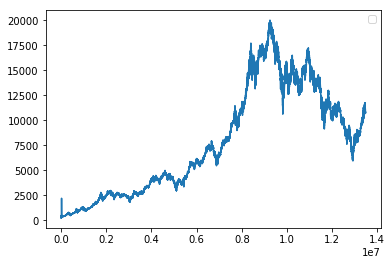

In [29]:
plotline(df['Fill Price (USD)'].values.flatten())

No handles with labels found to put in legend.


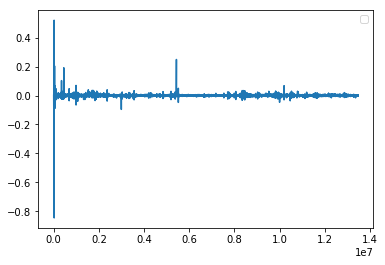

In [30]:
plotline(all_y[:,0])

No handles with labels found to put in legend.


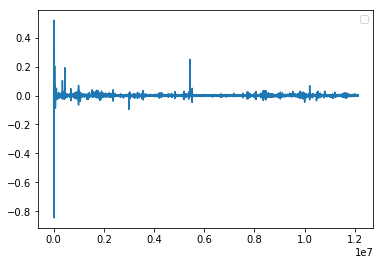

No handles with labels found to put in legend.


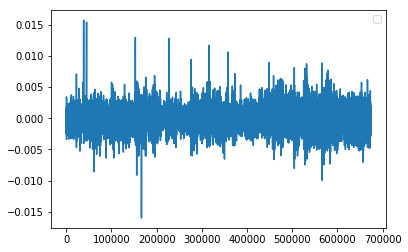

No handles with labels found to put in legend.


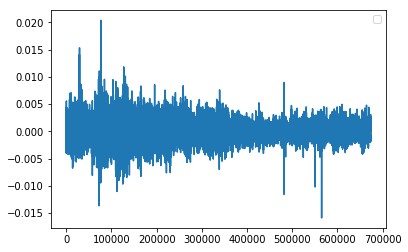

In [31]:
plotline(Y_train[:,0])
plotline(Y_dev[:,0])
plotline(Y_test[:,0])

In [32]:
# making the training set smaller so we train faster
downscaling_factor = 1
#downscaling_factor = 100
fraction_used = 1 / downscaling_factor
fraction_skipped = 1 - fraction_used
samples_skipped = round(X_train.shape[0] * fraction_skipped)
print(X_train.shape)
#X_train = X_train[::downscaling_factor]
#Y_train = Y_train[::downscaling_factor]
X_train = X_train[samples_skipped::]
Y_train = Y_train[samples_skipped::]
print(X_train.shape)

(12126797, 1, 3)
(12126797, 1, 3)


In [33]:
X_sample = all_features[0:10]
Y_sample = all_y[0:10]
print(X_sample)
print(Y_sample)

[[[0.0000000e+00 0.0000000e+00 1.0000000e+00]]

 [[1.8556701e-03 1.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[4.1160733e-05 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 1.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 1.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 1.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[1.6463615e-04 0.0000000e+00 0.0000000e+00]]]
[[1.8556701e-03]
 [0.0000000e+00]
 [4.1160733e-05]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.6463615e-04]
 [0.0000000e+00]]


In [34]:
def event_count(time_series, data_name):
  time_series = time_series[['Fill Price (USD)']].values
  upevents = 0
  downevents = 0
  sameprice = 0
  prev_obv = time_series[0]
  for obv in time_series[1:]:
      if obv > prev_obv:
          upevents += 1
      elif obv < prev_obv:
          downevents += 1
      elif obv == prev_obv:
          sameprice += 1
      prev_obv = obv
  print('=== Event counts on %s ===' % data_name)
  print('upevents')
  print(upevents)
  print('downevents')
  print(downevents)
  print('sameprice')
  print(sameprice)
  print()

def mse(time_series, data_name):
  time_series = time_series[['Fill Price (USD)']].values
  total_squared_error = 0
  total_absolute_error = 0
  prev_obv = time_series[0]
  for obv in time_series[1:]:
    total_squared_error += (obv - prev_obv)**2
    total_absolute_error += abs(obv - prev_obv)
    prev_obv = obv
  num_predictions = len(time_series) - 1
  mean_squared_error = total_squared_error / num_predictions
  mean_absolute_error = total_absolute_error / num_predictions
  root_mean_squared_error = np.sqrt(mean_squared_error)
  print('=== baseline on %s ===' % data_name)
  print('total squared error')
  print(total_squared_error)
  print('total absolute error')
  print(total_absolute_error)
  print('mean squared error')
  print(mean_squared_error)
  print('mean absolute error')
  print(mean_absolute_error) 
  print('root mean squared error')
  print(root_mean_squared_error) 
  print()

In [35]:
def show_summary_statistics():
  #event_count(small_set, 'small')
  train_set = df.iloc[0:num_samples_training]
  dev_set = df.iloc[num_samples_training:num_samples_training+num_samples_dev]
  test_set = df.iloc[num_samples_training+num_samples_dev:]
  event_count(train_set, 'train')
  event_count(dev_set, 'dev')
  event_count(test_set, 'test')
  mse(train_set, 'train')
  mse(dev_set, 'dev')
  mse(test_set, 'test')

#show_summary_statistics()

In [36]:
def preprocess(data):
    values = np.array(data)
    values = values.reshape(-1,1)
    values = values.astype('float32') 
    return values

In [37]:
def plot_losses(model_history, title):
  plt.figure()
  plt.plot(model_history.history['loss'], label='Train')
  plt.plot(model_history.history['val_loss'], label='Dev')
  plt.xlabel('Epochs'); plt.ylabel('Loss (mse)')
  plt.title(title)
  plt.legend(); plt.show()

In [38]:
def inverse_transform_pricescaler(data, Y_prevrawprice, fitted_scaler):
    return fitted_scaler.inverse_transform(preprocess(data))

def inverse_transform_percentdiff(data, Y_prevrawprice, fitted_scaler=None):
    orig_prices = Y_prevrawprice
    change = orig_prices * data
    return orig_prices + change
    #return fitted_scaler.inverse_transform(preprocess(data))

#print(Y_test_prevrawprice)
#print(inverse_transform_percentdiff(Y_test, Y_test_prevrawprice))

inverse_transform = inverse_transform_percentdiff


In [39]:
def plot_predictions(model, X_test, Y_test, Y_prevrawprice, title, inverse=False, scaler=None):
  y_hat = model.predict(X_test)

  if inverse:
      y_hat = inverse_transform(y_hat, Y_prevrawprice, scaler)
      Y_test = inverse_transform(Y_test, Y_prevrawprice, scaler)

  plt.plot(y_hat, label='Predicted')
  plt.plot(Y_test, label='True')
  plt.xlabel('Time'); 

  if inverse:
      plt.ylabel('Price')
  else:
      plt.ylabel('RESCALED Price')

  plt.title(title)
  plt.legend(); plt.show()

In [40]:
def calculate_MSE_RMSE(model, scaler, X_test, Y_test, Y_prevrawprice, model_name):
  y_hat = model.predict(X_test)
  y_hat_inverse = inverse_transform(y_hat, Y_prevrawprice, scaler)
  Y_test_inverse = inverse_transform(Y_test, Y_prevrawprice, scaler)
  mse = mean_squared_error(Y_test_inverse, y_hat_inverse)
  rmse = np.sqrt(mean_squared_error(Y_test_inverse, y_hat_inverse))
  print('%s:' % model_name)
  print('Test MSE: %.3f' % mse)
  print('Test RMSE: %.3f' % rmse)
  print()

In [41]:
def train_evaluate(model, model_name, 
                   X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
                   lag=10, batch_size=100, epochs=10, verbose=1):

  # Train model
  history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                      validation_split=0.05, verbose=verbose, shuffle=False)
  #train_evaluate_showresults(history, model, model_name, 
  #                 X_train, Y_train, X_dev, Y_dev, X_test, Y_test,
  #                 lag, batch_size, epochs, verbose)
  return history

In [42]:
def train_evaluate_showresults(history, model, model_name, 
                   X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
                   lag=10, batch_size=100, epochs=10, verbose=1):
  # Plot losses, predictions, and calculate MSE and RMSE
  plot_losses(history, 'Loss\n(%s)' % model_name)
  plot_predictions(model, X_dev, Y_dev, Y_dev_prevrawprice, 'Test Predictions\n(%s)' % model_name)
  plot_predictions(model, X_dev, Y_dev, Y_dev_prevrawprice, 'Test Predictions\n(%s)' % model_name, inverse=True, scaler=price_scaler)
  calculate_MSE_RMSE(model, price_scaler, X_dev, Y_dev, Y_dev_prevrawprice, '%s' % model_name)

In [43]:
def evaluate_test(model, model_name, 
                   X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
                   lag=10, batch_size=100, epochs=10, verbose=1):
    
  # Train model
  #history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
  #                    validation_split=0.05, verbose=verbose, shuffle=False)

  # Plot losses, predictions, and calculate MSE and RMSE
  #plot_losses(history, 'Loss\n(%s)' % model_name)
  plot_predictions(model, X_test, Y_test, Y_test_prevrawprice, 'Test Predictions\n(%s)' % model_name)
  plot_predictions(model, X_test, Y_test, Y_test_prevrawprice, 'Test Predictions\n(%s)' % model_name, inverse=True, scaler=price_scaler)
  calculate_MSE_RMSE(model, price_scaler, X_test, Y_test, Y_test_prevrawprice, '%s' % model_name)

In [44]:
# HYPERPARAMETERS
#####################
lag = 1
loss = 'mean_squared_error'
optimizer = 'adagrad' # sgd, adagrad, adam, rmsprop, adagrad
batch_size = 100
epochs = 20
model_name = 'model_LAG-%s_LOSS-%s_OPT-%s_BATCHSIZE-%s_EPOCHS-%s' % (lag, loss, optimizer, batch_size, epochs)
#####################


LSTM_input_shape = [X_train.shape[1], X_train.shape[2]]

In [45]:
# DEFINE MODEL
model = Sequential()

##################### 
model.add(LSTM(200, input_shape=LSTM_input_shape, return_sequences=True))
model.add(Dropout(0.1))

#model.add(LSTM(50, input_shape=LSTM_input_shape, return_sequences=True))
#model.add(Dropout(0.1))

#model.add(LSTM(200, input_shape=LSTM_input_shape, return_sequences=True))
#model.add(Dropout(0.1))

#model.add(LSTM(200, input_shape=LSTM_input_shape, return_sequences=True))
#model.add(Dropout(0.1))

model.add(LSTM(200, input_shape=LSTM_input_shape, return_sequences=True))
model.add(Dropout(0.1))

#model.add(LSTM(256, input_shape=LSTM_input_shape, return_sequences=True))

model.add(LSTM(200, return_sequences=False))
#model.add(Dropout(0.1))

model.add(Dense(1))
#model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01)))

model.add(Activation('linear'))
#####################

model.compile(loss=loss, optimizer=optimizer)

In [46]:
print(X_train.shape)
print(Y_train.shape)
print(X_train)

(12126797, 1, 3)
(12126797, 1)
[[[0.         0.         1.        ]]

 [[0.00185567 1.         0.        ]]

 [[0.         0.         0.        ]]

 ...

 [[0.         1.         0.        ]]

 [[0.         0.         0.        ]]

 [[0.         1.         0.        ]]]


In [47]:
# Train/evaluate model
history = train_evaluate(model, model_name,
               X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
               lag=lag, batch_size=batch_size, epochs=epochs, verbose=1)

Train on 11520457 samples, validate on 606340 samples
Epoch 1/20
11520457/11520457 [==============================] - 1153s 100us/step - loss: 4.0764e-07 - val_loss: 3.0221e-07
Epoch 2/20
11520457/11520457 [==============================] - 1158s 101us/step - loss: 3.6873e-07 - val_loss: 3.0227e-07
Epoch 3/20
11520457/11520457 [==============================] - 1164s 101us/step - loss: 3.6868e-07 - val_loss: 3.0219e-07
Epoch 4/20
11520457/11520457 [==============================] - 1199s 104us/step - loss: 3.6865e-07 - val_loss: 3.0218e-07
Epoch 5/20
11520457/11520457 [==============================] - 1177s 102us/step - loss: 3.6863e-07 - val_loss: 3.0211e-07
Epoch 6/20
11520457/11520457 [==============================] - 1032s 90us/step - loss: 3.6860e-07 - val_loss: 3.0211e-07
Epoch 7/20
11520457/11520457 [==============================] - 1172s 102us/step - loss: 3.6858e-07 - val_loss: 3.0199e-07
Epoch 8/20
11520457/11520457 [==============================] - 1125s 98us/step - loss

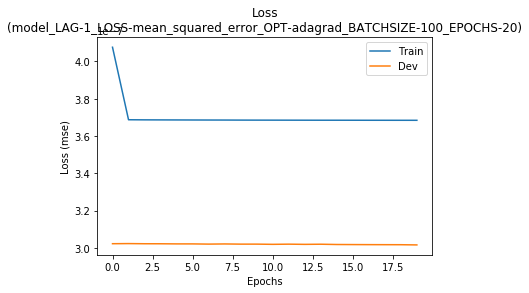

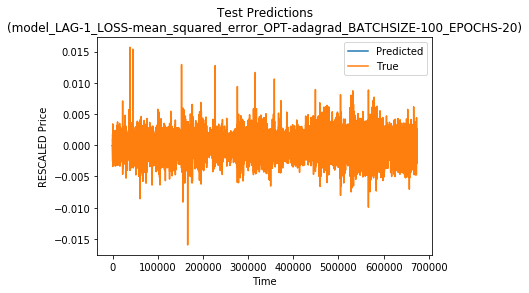

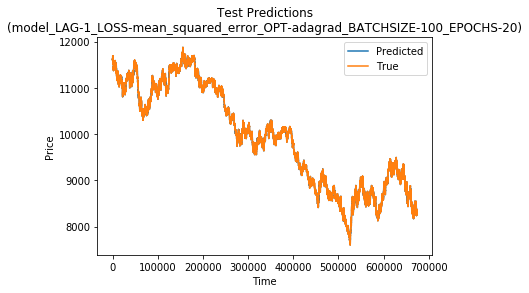

model_LAG-1_LOSS-mean_squared_error_OPT-adagrad_BATCHSIZE-100_EPOCHS-20:
Test MSE: 15.222
Test RMSE: 3.902



In [48]:
train_evaluate_showresults(history, model, model_name,
               X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
               lag, batch_size, epochs)

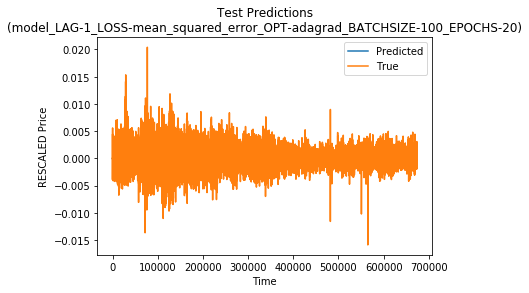

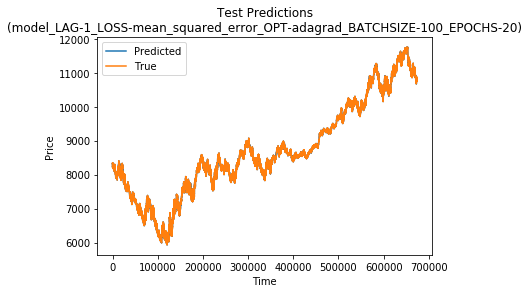

model_LAG-1_LOSS-mean_squared_error_OPT-adagrad_BATCHSIZE-100_EPOCHS-20:
Test MSE: 17.053
Test RMSE: 4.130



In [49]:
# Train/evaluate model
evaluate_test(model, model_name,
              X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
              lag=lag, batch_size=batch_size, epochs=epochs, verbose=1)